In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
sys.path.append("../")
import torch
assert torch.cuda.is_available()
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch.nn as nn
from tqdm.auto import tqdm
import json
from train import eval
from Utils import load
plt.rcParams["font.family"] = "Segoe UI"

In [ ]:
pruners = np.array(
    [
        # 'cs',
        # 'grasp',
        # 'sf',
        # 'mica_cs_shuffle',
        # 'mica_grasp_shuffle',
        # 'mica_sf_shuffle',
        'mica_erk_shuffle',
        'mica_igq_shuffle',
        # 'mica_cs_rand',
        # 'mica_grasp_rand',
        # 'mica_sf_rand',
        'mica_erk_rand',
        'mica_igq_rand'
    ],
    dtype=object
    )

colors = {
    'cs'         : plt.cm.tab10(9),
    'grasp'      : plt.cm.tab10(8),
    'sf'         : plt.cm.tab10(6),
    'mica_cs'    : plt.cm.tab10(9),
    'mica_grasp' : plt.cm.tab10(8),
    'mica_sf'    : plt.cm.tab10(6),
    'mica_erk'   : plt.cm.tab10(4),
    'mica_igq'   : plt.cm.tab10(3),
}

markers = {
    'cs'         : "^", 
    'grasp'      : "h", 
    'sf'         : "H", 
    'mica_cs'    : "^", 
    'mica_grasp' : "h", 
    'mica_sf'    : "H",
    'mica_erk'   : "p", 
    'mica_igq'   : "*"
}

pruner_names = {
    'cs'                 : 'RbPI-SNIP',
    'grasp'              : 'RbPI-GraSP',
    'sf'                 : 'RbPI-SynFlow',
    'mica_cs_shuffle'    : 'RPI-SNIP',
    'mica_grasp_shuffle' : 'RPI-GraSP',
    'mica_sf_shuffle'    : 'RPI-SynFlow',
    'mica_erk_shuffle'   : 'RPI-ERK',
    'mica_igq_shuffle'   : 'RPI-IGQ',
    'mica_cs_rand'       : '$\\bf{MiCA}$-$\\bf{SNIP}$',
    'mica_grasp_rand'    : '$\\bf{MiCA}$-$\\bf{GraSP}$',
    'mica_sf_rand'       : '$\\bf{MiCA}$-$\\bf{SynFlow}$',
    'mica_erk_rand'      : '$\\bf{MiCA}$-$\\bf{ERK}$',
    'mica_igq_rand'      : '$\\bf{MiCA}$-$\\bf{IGQ}$',
    }

pepochs = {
    'cs'         : '1',
    'grasp'      : '1',
    'sf'         : '100',
    'mica_cs'    : '1',
    'mica_grasp' : '1',
    'mica_sf'    : '1',
    'mica_erk'   : '1',
    'mica_igq'   : '1',
}

for pruner in pruners:
    if '_shuffle' in pruner:
        colors[pruner]  = colors[pruner.replace('_shuffle', '')]
        markers[pruner]  = markers[pruner.replace('_shuffle', '')]
        pepochs[pruner] = pepochs[pruner.replace('_shuffle', '')]
    elif '_rand' in pruner:
        colors[pruner]  = colors[pruner.replace('_rand', '')]
        markers[pruner]  = markers[pruner.replace('_rand', '')]
        pepochs[pruner] = pepochs[pruner.replace('_rand', '')]

runs = [0, 1, 2]

max_run_num = len(runs)

print(pruners)

In [4]:
def get_experimentid(pruner, ratio, pepochs, run_num, expid):
    if '_shuffle' in pruner:
        base_dir = f'../Results/data/singleshot/{expid}_shuffle'
        p_name = pruner.replace('_shuffle', '')
    elif '_min' in pruner:
        base_dir = f'../Results/data/singleshot/{expid}_min'
        p_name = pruner.replace('_min', '')
    elif '_max' in pruner:
        base_dir = f'../Results/data/singleshot/{expid}_max'
        p_name = pruner.replace('_max', '')
    elif '_rand' in pruner:
        base_dir = f'../Results/data/singleshot/{expid}_rand'
        p_name = pruner.replace('_rand', '')
    else:
        base_dir = f'../Results/data/singleshot/{expid}'
        p_name = pruner
    b_dir  = f'{base_dir}'
    experimentid =  f'{b_dir}/' \
                    f'{p_name}-{ratio}-{pepochs}/' \
                    f'run_{run_num}/' 
    return experimentid

def zero_to_nan(values):
    return [float('nan') if x==0 else x for x in values]

def get_ordered_list(l, order):
    out = []
    for i in order:
        out.append(l[i])
    return out

In [ ]:
expid = 'cifar10_lottery_resnet20'
ratios = [
    '0.5', '1.0', '1.5', '2.0', 
    '2.5', '3.0', '3.5', '4.0', 
    ]

resnet_edges = {}
resnet_effective_edges = {}
for l, pruner in enumerate(pruners):
    resnet_edges[pruner]           = np.zeros((len(ratios)))
    resnet_effective_edges[pruner] = np.zeros((len(ratios)))
    for i, ratio in enumerate(tqdm(ratios, desc=pruner)): 
        edges = []
        effective_edges = []
        for r, run_num in enumerate(runs):
            experimentid      = get_experimentid(pruner, ratio, pepochs[pruner], run_num, expid)
            model_file        = experimentid + 'model.pt'
            train_result_file = experimentid + 'post-train.pkl'
            compression_file  = experimentid + 'compression.pkl'
            train_result      = pd.read_pickle(train_result_file)
            compression       = pd.read_pickle(compression_file)
            prunable          = compression['prunable']==True
            weight            = compression['param']=='weight'
            modules           = compression[np.logical_and(prunable, weight)]['module']
            densities         = np.array(compression[np.logical_and(prunable, weight)]['density'])
            shape             = compression[np.logical_and(prunable,weight)]['shape']
            e                 = np.array([np.prod(s) for s in shape]) * (densities)
            edges.append(np.sum(e))

            with open(experimentid + 'args.json') as f:
                args = json.load(f)
            input_shape, num_classes = load.dimension(args['dataset']) 
            loss = nn.CrossEntropyLoss()
            if i == 0 and r == 0:
                test_loader, _, _ = load.dataloader(
                    args['dataset'], args['test_batch_size'], args['test_batch_size'],
                    False, args['workers'], 0, 0)
                dataset = args['dataset']
                test_batch_size = args['test_batch_size']
                workers = args['workers']
                (data, _) = next(iter(test_loader))
                input_dim = list(data[0,:].shape)
                input = torch.ones([1] + input_dim).to('cuda')
            assert args['seed'] == run_num * 1000 # adhoc
            assert args['run_number'] == str(run_num)
            assert dataset == args['dataset']
            assert test_batch_size == args['test_batch_size']
            assert workers == args['workers']

            model = load.model(args['model'], args['model_class'])(
                input_shape, num_classes, args['dense_classifier'], args['pretrained']).to('cuda')
            model.load_state_dict(torch.load(model_file))

            print(f'Forward :')
            model.set_effective_sparsity(is_forward=True, x=input)
            print(f'Backward :')
            model.set_effective_sparsity(is_forward=False, x=None)

            effective_densities = []
            set_modules = set(modules.unique())
            for n, m in model.named_modules():
                if hasattr(m, 'weight_mask') and n in set_modules:
                    effective_densities.append((m.weight_mask.sum() / m.weight_mask.numel()).to('cpu'))
            effective_densities = np.array(effective_densities)
            e = np.array([np.prod(s) for s in shape]) * (effective_densities)
            effective_edges.append(np.sum(e))

        resnet_edges[pruner][i]           = np.mean(edges)    
        resnet_effective_edges[pruner][i] = np.mean(effective_edges)

In [ ]:
expid = 'cifar10_lottery_vgg16_bn'
ratios = [
    '0.5', '1.0', '1.5', '2.0', 
    '2.5', '3.0', '3.5', '4.0', 
    '4.5', '5.0', '5.5', '6.0', 
    ]

vgg_edges = {}
vgg_effective_edges = {}
for l, pruner in enumerate(pruners):
    vgg_edges[pruner]           = np.zeros((len(ratios)))
    vgg_effective_edges[pruner] = np.zeros((len(ratios)))
    for i, ratio in enumerate(tqdm(ratios, desc=pruner)): 
        edges = []
        effective_edges = []
        for r, run_num in enumerate(runs):
            experimentid      = get_experimentid(pruner, ratio, pepochs[pruner], run_num, expid)
            model_file        = experimentid + 'model.pt'
            train_result_file = experimentid + 'post-train.pkl'
            compression_file  = experimentid + 'compression.pkl'
            train_result      = pd.read_pickle(train_result_file)
            compression       = pd.read_pickle(compression_file)
            prunable          = compression['prunable']==True
            weight            = compression['param']=='weight'
            modules           = compression[np.logical_and(prunable, weight)]['module']
            densities         = np.array(compression[np.logical_and(prunable, weight)]['density'])
            shape             = compression[np.logical_and(prunable,weight)]['shape']
            e                 = np.array([np.prod(s) for s in shape]) * (densities)
            edges.append(np.sum(e))

            with open(experimentid + 'args.json') as f:
                args = json.load(f)
            input_shape, num_classes = load.dimension(args['dataset']) 
            loss = nn.CrossEntropyLoss()
            if i == 0 and r == 0:
                test_loader, _, _ = load.dataloader(
                    args['dataset'], args['test_batch_size'], args['test_batch_size'],
                    False, args['workers'], 0, 0)
                dataset = args['dataset']
                test_batch_size = args['test_batch_size']
                workers = args['workers']
                (data, _) = next(iter(test_loader))
                input_dim = list(data[0,:].shape)
                input = torch.ones([1] + input_dim).to('cuda')
            assert args['seed'] == run_num * 1000 # adhoc
            assert args['run_number'] == str(run_num)
            assert dataset == args['dataset']
            assert test_batch_size == args['test_batch_size']
            assert workers == args['workers']

            model = load.model(args['model'], args['model_class'])(
                input_shape, num_classes, args['dense_classifier'], args['pretrained']).to('cuda')
            model.load_state_dict(torch.load(model_file))

            print(f'Forward :')
            model.set_effective_sparsity(is_forward=True, x=input)
            print(f'Backward :')
            model.set_effective_sparsity(is_forward=False, x=None)

            effective_densities = []
            set_modules = set(modules.unique())
            for n, m in model.named_modules():
                if hasattr(m, 'weight_mask') and n in set_modules:
                    effective_densities.append((m.weight_mask.sum() / m.weight_mask.numel()).to('cpu'))
            effective_densities = np.array(effective_densities)
            e = np.array([np.prod(s) for s in shape]) * (effective_densities)
            effective_edges.append(np.sum(e))

        vgg_edges[pruner][i]           = np.mean(edges)    
        vgg_effective_edges[pruner][i] = np.mean(effective_edges)

In [7]:
lw=4
markersize=30
fontsize=35


0, Total
1, $\bf{MiCA}$-$\bf{ERK}$
2, RPI-ERK
3, $\bf{MiCA}$-$\bf{IGQ}$
4, RPI-IGQ


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


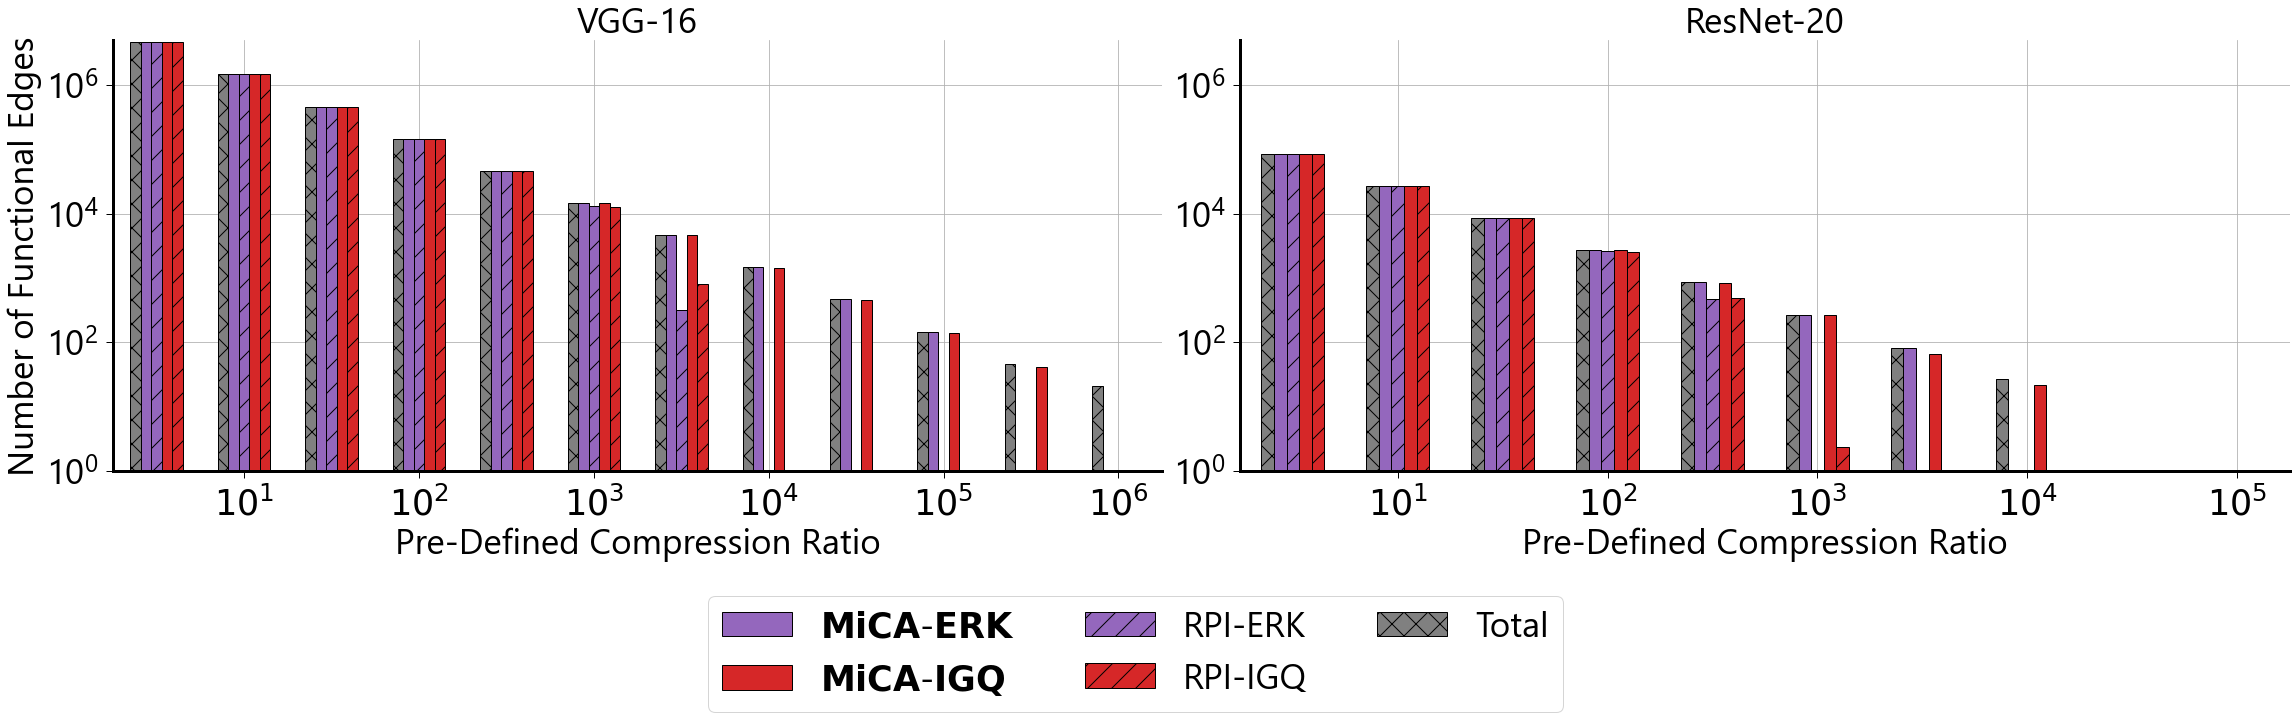

In [8]:
plot_pruners = [
    'mica_erk_rand',
    'mica_erk_shuffle',
    'mica_igq_rand',
    'mica_igq_shuffle',
    ]

fig, axes = plt.subplots(1, 2, figsize=(8*4, 8))

bar_width = 0.12
for i, arch in enumerate(['vgg', 'resnet']):
    if arch == 'vgg':
        effective_edges = vgg_effective_edges
        edges = vgg_edges
        xticks = np.arange(12) - bar_width * 2
    elif arch == 'resnet':
        effective_edges = resnet_effective_edges
        edges = resnet_edges 
        xticks = np.arange(8) - bar_width * 2
    ax = axes[i]

    for l, pruner in enumerate(plot_pruners):
        if l == 0:
            ax.bar(xticks, edges[pruner], color='gray', 
                    label='Total', hatch='x',
                    width=bar_width, ec="k",
                    align='center')
            xticks += bar_width

        if '_shuffle' in pruner:
            ax.bar(xticks, effective_edges[pruner], color=colors[pruner], 
                    label=pruner_names[pruner], hatch='/', 
                    width=bar_width, ec="k", 
                    align='center')
        elif 'mica' in pruner:
            ax.bar(xticks, effective_edges[pruner], color=colors[pruner], 
                    label=pruner_names[pruner],
                    width=bar_width, ec="k",
                    align='center')
        xticks += bar_width

    ax.set_ylim(1, 10**6.7)
    ax.set_yscale('log')
    ax.set_xticks(np.arange(1, 12, 2))
    ax.set_xticklabels([fr'$10^{i}$' for i in np.arange(1, 7)])
    if arch == 'vgg':
        ax.set_xlim(-.5, 11.5)
    else:
        ax.set_xlim(-.5, 9.5)
    # ax.set_yticks(np.arange(10, 100, 20))
    ax.minorticks_off()
    ax.set_axisbelow(True)
    
    ax.tick_params(
        which       = "both", bottom    = True,  top   = False,
        labelbottom = True,   left      = True,  right = False,
        labelleft   = True,   
        direction   = 'out',  length    = 7,     width = 1.0,    
        pad         = 8,      labelsize = fontsize
        )
    ax.set_title('VGG-16' if arch == 'vgg' else 'ResNet-20', size=fontsize)
    ax.set_xlabel('Pre-Defined Compression Ratio', size=fontsize)
    if i == 0:
        ax.set_ylabel('Number of Functional Edges', size=fontsize)
    ax.grid()
    

    # boundary and zoom box
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)
    ax.spines["right"].set_linestyle((0,(3,3)))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.subplots_adjust(hspace=0.2)
fig.tight_layout()

handles, labels = ax.get_legend_handles_labels()
for nl, label in enumerate(labels):
    print(f'{nl}, {label}')
order = [1,3,2,4,0]
ordered_handles = get_ordered_list(handles, order)
ordered_labels = get_ordered_list(labels, order)
plt.legend(
    handles=ordered_handles,labels=ordered_labels, 
    fontsize=fontsize, loc='upper center', 
    bbox_to_anchor=(-.1, -.25), ncol=3)
os.makedirs('Plots', exist_ok=True)
plt.savefig('./Plots/cifar10_sparsity_dist.eps', bbox_inches="tight")
plt.savefig('./Plots/cifar10_sparsity_dist.svg', bbox_inches="tight")
plt.savefig('./Plots/cifar10_sparsity_dist.pdf', bbox_inches="tight")

vgg
[4.65347289e+06 1.47155702e+06 4.65345008e+05 1.47157998e+05
 4.65379995e+04 1.47140003e+04 4.65599994e+03 1.46699998e+03
 4.67000006e+02 1.46000000e+02 4.70000013e+01 2.10000005e+01]
vgg
[4.65347289e+06 1.47155702e+06 4.65345008e+05 1.47157998e+05
 4.65379995e+04 1.47140003e+04 4.65599994e+03 1.46699998e+03
 4.67000006e+02 1.46000000e+02 4.70000013e+01 2.10000005e+01]
vgg
[4.65347109e+06 1.47154898e+06 4.65342005e+05 1.47148999e+05
 4.65280003e+04 1.47070002e+04 4.64800009e+03 1.46200004e+03
 4.61000008e+02 1.40000005e+02 4.20000012e+01 0.00000000e+00]
vgg
[4.65347109e+06 1.47154898e+06 4.65342005e+05 1.47148999e+05
 4.65280003e+04 1.47070002e+04 4.64800009e+03 1.46200004e+03
 4.61000008e+02 1.40000005e+02 4.20000012e+01 0.00000000e+00]
resnet
[8.56670008e+04 2.70910000e+04 8.56099994e+03 2.71499998e+03
 8.60000002e+02 2.66999999e+02 8.20000015e+01 2.70000005e+01]
resnet
[8.56670008e+04 2.70910000e+04 8.56099994e+03 2.71499998e+03
 8.60000002e+02 2.66999999e+02 8.20000015e+01 2.70

<ipython-input-12-64c9ba7c04cc>:44: RuntimeWarning: invalid value encountered in divide
  ax.bar(xticks, np.array(effective_edges[pruner])/np.array(edges[pruner]), color=colors[pruner],
<ipython-input-12-64c9ba7c04cc>:39: RuntimeWarning: invalid value encountered in divide
  ax.bar(xticks, np.array(effective_edges[pruner])/np.array(edges[pruner]), color=colors[pruner],
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


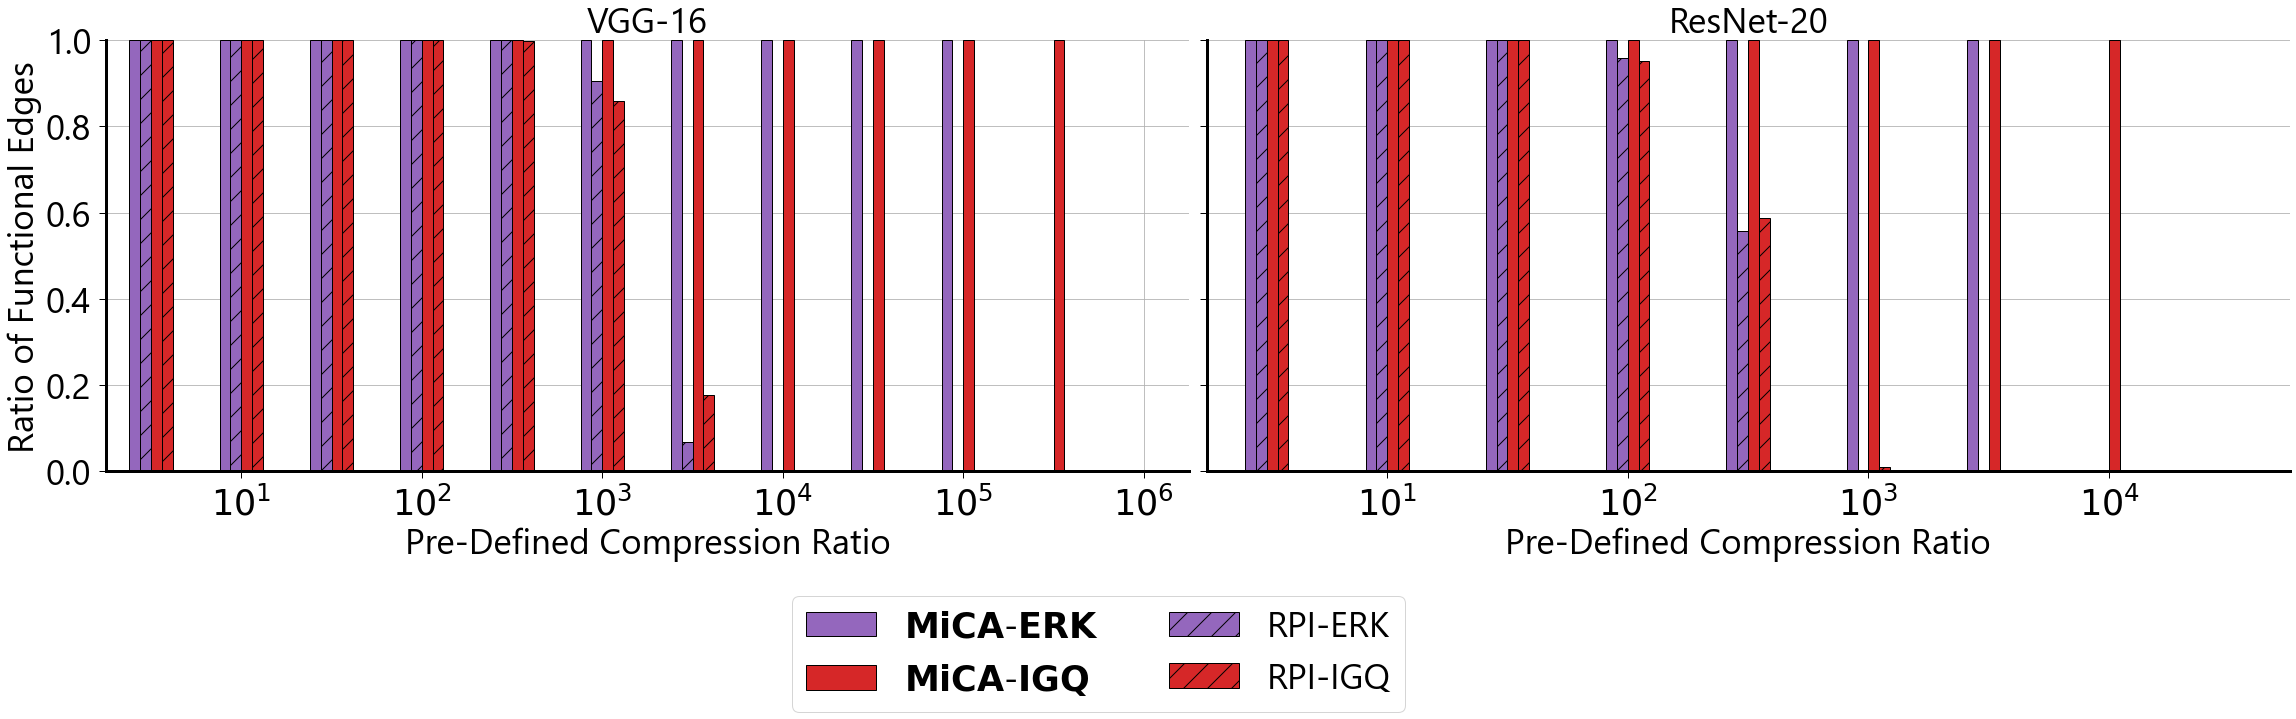

In [12]:
plot_pruners = [
    'mica_erk_rand',
    'mica_erk_shuffle',
    'mica_igq_rand',
    'mica_igq_shuffle',
    ]

fig, axes = plt.subplots(1, 2, figsize=(8*4, 8))


for i, arch in enumerate(['vgg', 'resnet']):
    if arch == 'vgg':
        xmin = -.5
        xmax = 11.5
        bar_width = (xmax-xmin)/100
        effective_edges = vgg_effective_edges
        edges = vgg_edges
        xticks = np.arange(12) - bar_width * 2
    elif arch == 'resnet':
        xmin = -.5
        xmax = 8.5
        bar_width = (xmax-xmin)/100
        effective_edges = resnet_effective_edges
        edges = resnet_edges 
        xticks = np.arange(8) - bar_width * 2
    
    ax = axes[i]

    for l, pruner in enumerate(plot_pruners):
        # if l == 0:
        #     ax.bar(xticks, edges[pruner], color='gray', 
        #             label='Total', hatch='x',
        #             width=bar_width, ec="k",
        #             align='center')
        #     xticks += bar_width
        print(arch)
        print(edges[pruner])
        if '_shuffle' in pruner:
            ax.bar(xticks, np.array(effective_edges[pruner])/np.array(edges[pruner]), color=colors[pruner], 
                    label=pruner_names[pruner], hatch='/', 
                    width=bar_width, ec="k", 
                    align='edge')
        elif 'mica' in pruner:
            ax.bar(xticks, np.array(effective_edges[pruner])/np.array(edges[pruner]), color=colors[pruner], 
                    label=pruner_names[pruner],
                    width=bar_width, ec="k",
                    align='edge')
        xticks += bar_width

    # ax.set_ylim(1, 10**6.7)
    # ax.set_yscale('log')
    ax.set_ylim(0, 1)
    ax.set_xticks(np.arange(1, 12, 2))
    ax.set_xticklabels([fr'$10^{i}$' for i in np.arange(1, 7)])
    if arch == 'vgg':
        ax.set_xlim(-.5, 11.5)
    else:
        ax.set_xlim(-.5, 8.5)
    # ax.set_yticks(np.arange(10, 100, 20))
    ax.minorticks_off()
    ax.set_axisbelow(True)
    
    ax.tick_params(
        which       = "both", bottom    = True,  top   = False,
        labelbottom = True,   left      = True,  right = False,
        labelleft   = True if arch == 'vgg' else False,   
        direction   = 'out',  length    = 7,     width = 1.0,    
        pad         = 8,      labelsize = fontsize
        )
    ax.set_title('VGG-16' if arch == 'vgg' else 'ResNet-20', size=fontsize)
    ax.set_xlabel('Pre-Defined Compression Ratio', size=fontsize)
    if i == 0:
        ax.set_ylabel('Ratio of Functional Edges', size=fontsize)
    ax.grid()
    

    # boundary and zoom box
    for dir in ["top", "bottom", "right", "left"]:
        ax.spines[dir].set_linewidth(3)
    ax.spines["right"].set_linestyle((0,(3,3)))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

fig.subplots_adjust(hspace=0.2)
fig.tight_layout()

handles, labels = ax.get_legend_handles_labels()
for nl, label in enumerate(labels):
    print(f'{nl}, {label}')
order = [0,2,1,3]
ordered_handles = get_ordered_list(handles, order)
ordered_labels = get_ordered_list(labels, order)
plt.legend(
    handles=ordered_handles,labels=ordered_labels, 
    fontsize=fontsize, loc='upper center', 
    bbox_to_anchor=(-.1, -.25), ncol=2)
os.makedirs('Plots', exist_ok=True)
plt.savefig('./Plots/cifar10_sparsity_dist.eps', bbox_inches="tight")
plt.savefig('./Plots/cifar10_sparsity_dist.svg', bbox_inches="tight")
plt.savefig('./Plots/cifar10_sparsity_dist.pdf', bbox_inches="tight")